In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
# import tensorwatch as tw
import time

import torch
import copy
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

from utils.dataset import *
import torch.utils.data as data

from utils.train import *
from utils.test  import *
from utils.model_select import model_select

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [2]:
# Training settings
####### test作训练集 #######
# epochs = 80
# lr = 3e-6
# gamma = 0.7
# step_size = 5
###### train作训练集 #######
epochs = 5
lr = 2e-6
gamma = 0.8
step_size = 2

seed = 42
device = 'cuda:1'

file_Path = '/home/a611/Projects/Datasets/CSE_v1/images/'
train_name = ['/home/a611/Projects/Datasets/CSE_v1/labels/train_aver_75.csv']
test_name = ['/home/a611/Projects/Datasets/CSE_v1/labels/train_aver_25.csv']
num_classes = 11
num_input = 3
batch_size = 16
num_workers = 8
########################
os.chdir('examples')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## Load Data

In [4]:
train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

## Load Datasets

In [5]:
label_map = get_map(test_name)
label_key = list(label_map.keys())
train_set = MyDataset(file_Path, train_name, label_map,
                            train_transforms)
train_loader = data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

valid_set = MyDataset(file_Path, test_name, label_map,
                            val_transforms)
valid_loader = data.DataLoader(
    dataset=valid_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [6]:
print(len(train_loader))
print(len(valid_loader))

557
186


## Effecient Attention

### Training

In [7]:
model = model_select('ResNet18', num_input, 90).to(device)
# print(model)
model = torch.nn.DataParallel(model)
model_state_disk = torch.load('/home/a611/Projects/msk/fewshot_main/Model/pretrain/ResNet18/test_acc_0.766925_epoch_159')
model.load_state_dict(model_state_disk)
model = model.module
model.linear = torch.nn.Linear(512, num_classes)

model = model.to(device)
# print(model)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
# model_ = None
# highest_test_acc = 0
# for i in range(epochs):
#     # print('EPOCH:', i + 1)
#     train_iter = iter(train_loader)
#     test_iter = iter(valid_loader)
#     ########################################
#     train_loss, train_acc = train(model, device, train_iter, optimizer, train_set, batch_size)
#     test_loss, test_acc = test(model, device, test_iter, valid_set, batch_size)
#     scheduler.step()
#     print( 'EPOCH: %03d, train_loss: %3f, train_acc: %3f, test_loss: %3f, test_acc: %3f'
#           % (i + 1, train_loss, train_acc, test_loss, test_acc))
#     if test_acc > highest_test_acc:
#         highest_test_acc = test_acc
#         model_ = copy.deepcopy(model)
#         print('Highest test accuracy: %3f' % highest_test_acc)
#         torch.save(model_, '../models/CSE_train.model')
# #     print( 'EPOCH: %03d, train_loss: %3f, train_acc: %3f' % (i + 1, train_loss, train_acc))

In [9]:
model = torch.load('../models/CSE_train.model')
# print(model.layer4)

In [36]:
def draw(x, output):
    output_max = output.argmax(dim=1)
    output_numpy = output.cpu().detach().numpy()
    fig, ax = plt.subplots(figsize=(12, 8))
    y = output_numpy[0]
    ax.bar(x = x, height = y)
    ax.set_title('Item: %s.' % x[int(output_max)], fontsize=15);
    xticks = ax.get_xticks()
    for i in range(len(y)):
        xy = (xticks[i], y[i])
        s = '%03f' % y[i]
        ax.annotate(
            text=s,  # 要添加的文本
            xy=xy,  # 将文本添加到哪个位置
            fontsize=8,  # 标签大小
            color="red",  # 标签颜色
            ha="center",  # 水平对齐
            va="baseline"  # 垂直对齐
        )
        plt.savefig("../distribution.jpg")
    return output_max

def result(x, output, input_type):
    output_max = output.argmax(dim=1)
    print('Input: %s; Item: %s.' % (input_type, x[int(output_max)]))
    return output_max

Input: pepper_66_chess.jpg; Item: pepper.
Considered as apple.
Considered as bottle.
Considered as car.
Considered as container.
Considered as cup.
Considered as doll.
Considered as fleet.
Considered as headset.
Considered as milk.
Considered as pepper.
Considered as plant.


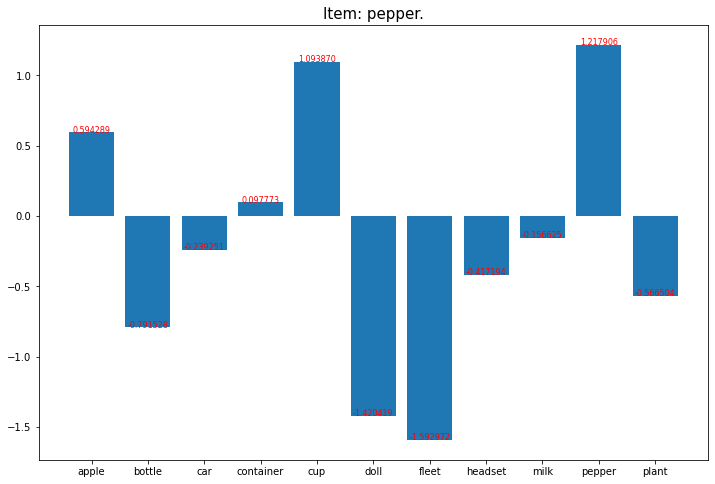

In [52]:
device = 'cpu'
model.eval()
model.to(device)
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
#########################################
# # for input_file_name in os.listdir('inputs'):
# input_file_name = 'doll_86.jpg'
# image_name = os.path.join('inputs',input_file_name)
# image = Image.open(image_name)
# img = image.resize((224, 224))
# input = test_transforms(image).unsqueeze(0)
# input = input.to(device)
# output = model(input)
# # output_max = draw(label_key, output)
# output_max = result(label_key, output, 'origin')
# output_max = draw(label_key, output, 'origin')

root_dir = '../sample_pairs'

catagories = os.listdir(root_dir)
catagories.sort()

rotation = 'same'
background = 'same'
image_name = 'pepper_66_chess.jpg'

image_path = '/home/a611/Projects/gyc/Local_Features/sample_pairs/%s_rotation_%s_background/%s' % (rotation, background, image_name)
image = Image.open(image_path)
img = image.resize((224, 224))
input = test_transforms(image).unsqueeze(0)
input = input.to(device)
output = model(input)
# print(output)
output_max = draw(label_key, output)
output_max = result(label_key, output, image_name)
#         output_max = draw(label_key, output, '%s, %s.' %(catagory, item))
for real_index in range(11):
    targets = [ClassifierOutputTarget(real_index)]
    grayscale_cam = cam(input_tensor=input, targets = targets)
    grayscale_cam = grayscale_cam[0, :]
    image_ = np.array(image, dtype=np.float32) / 255
    grayscale_cam = cv2.resize(grayscale_cam, (image_.shape[1], image_.shape[0]))
    visualization = show_cam_on_image(image_, grayscale_cam, use_rgb=True)

    im = Image.fromarray(visualization)

    im.save("../output.jpg")
    print('Considered as %s.' % label_key[real_index])
    time.sleep(2)